# Assignment 1 Code

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image, ImageOps
import copy

In [2]:
%matplotlib inline

In [3]:
# Number of classes in the dataset
num_classes = 10

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

RANDOM_SEED = 73

In [4]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = sorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        img_name = self.total_imgs[idx]
        label = int(img_name.split("_")[-1].split(".")[0])
        image = Image.open(img_loc)
        #image = ImageOps.grayscale(image)
        tensor_image = self.transform(image)
        #print(tensor_image.size())
        return tensor_image, label

## Base VGG

In [5]:
from sklearn.model_selection import KFold

k_folds = 5

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=RANDOM_SEED)

In [6]:
data_path = '/home/mayankg/adv_cv/dataset_preprocessed'
input_size = 224

#Define Dataset from path
transforms = transforms.Compose([
        transforms.Resize(input_size),
        #transforms.CenterCrop(input_size),
        transforms.ToTensor()])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


dataset = CustomDataSet(data_path, transform=transforms)

In [7]:
curr_fold = 0

train_id, test_id = None, None

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    if fold != curr_fold:
        continue
    
    train_id = train_ids
    test_id = test_ids
    
    break
    
print(len(train_id), len(test_id))

59676 14919


In [12]:
# Sample elements randomly from a given list of ids, no replacement.
train_subsampler = torch.utils.data.SubsetRandomSampler(train_id)
test_subsampler = torch.utils.data.SubsetRandomSampler(test_id)

# Define data loaders for training and testing data in this fold
train_loader = torch.utils.data.DataLoader(
                  dataset, 
                  batch_size=batch_size, sampler=train_subsampler)
valid_loader = torch.utils.data.DataLoader(
                  dataset,
                  batch_size=batch_size, sampler=test_subsampler)

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].sampler.indices)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].sampler.indices)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [7]:
def validate_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):    
    model.eval()   # Set model to evaluate mode
    
    running_loss = 0.0
    running_corrects = 0
    
    phase = 'val'
    
    # Iterate over data.
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
            # Get model outputs and calculate loss
            # Special case for inception because in training it has an auxiliary output. In train
            #   mode we calculate the loss by summing the final output and the auxiliary output
            #   but in testing we only consider the final output.
            if is_inception and phase == 'train':
                # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                outputs, aux_outputs = model(inputs)
                loss1 = criterion(outputs, labels)
                loss2 = criterion(aux_outputs, labels)
                loss = loss1 + 0.4*loss2
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / len(dataloaders[phase].sampler.indices)
    epoch_acc = running_corrects.double() / len(dataloaders[phase].sampler.indices)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


In [11]:
print(len(dataloaders_dict['train'].dataset))

NameError: name 'dataloaders_dict' is not defined

In [10]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    
    model_ft = models.vgg16(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    input_size = 224
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=False)

# Print the model we just instantiated
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
# Create training and validation dataloaders
dataloaders_dict = {'train': train_loader, 'val': valid_loader}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.2.weight
	 features.2.bias
	 features.5.weight
	 features.5.bias
	 features.7.weight
	 features.7.bias
	 features.10.weight
	 features.10.bias
	 features.12.weight
	 features.12.bias
	 features.14.weight
	 features.14.bias
	 features.17.weight
	 features.17.bias
	 features.19.weight
	 features.19.bias
	 features.21.weight
	 features.21.bias
	 features.24.weight
	 features.24.bias
	 features.26.weight
	 features.26.bias
	 features.28.weight
	 features.28.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [15]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 2.1997 Acc: 0.1745
val Loss: 1.4691 Acc: 0.5066

Epoch 1/14
----------
train Loss: 0.6530 Acc: 0.7872
val Loss: 0.1723 Acc: 0.9457

Epoch 2/14
----------
train Loss: 0.1612 Acc: 0.9486
val Loss: 0.0857 Acc: 0.9739

Epoch 3/14
----------
train Loss: 0.0924 Acc: 0.9707
val Loss: 0.0784 Acc: 0.9758

Epoch 4/14
----------
train Loss: 0.0625 Acc: 0.9794
val Loss: 0.0541 Acc: 0.9833

Epoch 5/14
----------
train Loss: 0.0468 Acc: 0.9847
val Loss: 0.0531 Acc: 0.9857

Epoch 6/14
----------
train Loss: 0.0374 Acc: 0.9876
val Loss: 0.0480 Acc: 0.9869

Epoch 7/14
----------
train Loss: 0.0289 Acc: 0.9905
val Loss: 0.0427 Acc: 0.9871

Epoch 8/14
----------
train Loss: 0.0244 Acc: 0.9919
val Loss: 0.0433 Acc: 0.9885

Epoch 9/14
----------
train Loss: 0.0187 Acc: 0.9941
val Loss: 0.0454 Acc: 0.9875

Epoch 10/14
----------
train Loss: 0.0162 Acc: 0.9945
val Loss: 0.0417 Acc: 0.9896

Epoch 11/14
----------
train Loss: 0.0136 Acc: 0.9952
val Loss: 0.0514 Acc: 0.9880

Ep

In [16]:
save_path = "models_vgg/model_vgg16_"+ str(curr_fold) + ".pth"
torch.save(model_ft.state_dict(), save_path)

file = open("models_vgg/vgg16_res_"+str(curr_fold) + ".txt", "w")
file.write(str(hist) + "\n")

file.close()

In [19]:
validate_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
for i in range(1, 5):
    
    curr_fold = i
    print("Starting Fold:", i)

    train_id, test_id = None, None

    # K-fold Cross Validation model evaluation
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

        if fold != curr_fold:
            continue

        train_id = train_ids
        test_id = test_ids

        break

    print(len(train_id), len(test_id))

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_id)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_id)

    # Define data loaders for training and testing data in this fold
    train_loader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=batch_size, sampler=train_subsampler)
    valid_loader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=batch_size, sampler=test_subsampler)

    # Initialize the model for this run
    model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=False)

    # Print the model we just instantiated
    #print(model_ft)

    # Create training and validation dataloaders
    dataloaders_dict = {'train': train_loader, 'val': valid_loader}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Send the model to GPU
    model_ft = model_ft.to(device)

    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.
    params_to_update = model_ft.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate
    model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

    save_path = "models_vgg/model_vgg16_"+ str(curr_fold) + ".pth"
    torch.save(model_ft.state_dict(), save_path)

    file = open("models_vgg/vgg16_res_"+str(curr_fold) + ".txt", "w")
    file.write(str(hist) + "\n")

    file.close()

Starting Fold: 1
59676 14919
Params to learn:
	 features.0.weight
	 features.0.bias
	 features.2.weight
	 features.2.bias
	 features.5.weight
	 features.5.bias
	 features.7.weight
	 features.7.bias
	 features.10.weight
	 features.10.bias
	 features.12.weight
	 features.12.bias
	 features.14.weight
	 features.14.bias
	 features.17.weight
	 features.17.bias
	 features.19.weight
	 features.19.bias
	 features.21.weight
	 features.21.bias
	 features.24.weight
	 features.24.bias
	 features.26.weight
	 features.26.bias
	 features.28.weight
	 features.28.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias
Epoch 0/14
----------
train Loss: 1.9988 Acc: 0.2633
val Loss: 0.8888 Acc: 0.7102

Epoch 1/14
----------
train Loss: 0.5181 Acc: 0.8317
val Loss: 0.1489 Acc: 0.9544

Epoch 2/14
----------
train Loss: 0.1585 Acc: 0.9496
val Loss: 0.0844 Acc: 0.9739

Epoch 3/14
----------
train Loss: 0.0889 Acc: 0.9718
val Loss: 0.05

In [34]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



def visualize_model(model, num_images=300):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders_dict['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):                
                if preds[j] == labels[j].data:
                    continue
                    
                images_so_far += 1
                ax = plt.subplot(5, 5, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, actual: {}'.format(preds[j], labels[j].data))
                imshow(inputs.cpu().data[j])

#                 if images_so_far == num_images:
#                     model.train(mode=was_training)
#                     return
        model.train(mode=was_training)

In [28]:
model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=False)
model_ft = model_ft.to(device)
model_ft.load_state_dict(torch.load("models_vgg/model_vgg16_best_0.pth"))

<All keys matched successfully>

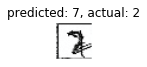

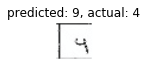

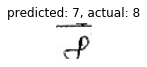

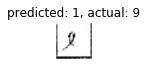

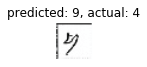

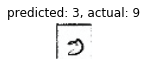

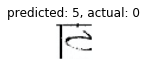

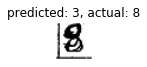

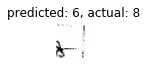

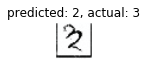

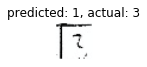

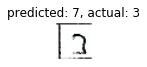

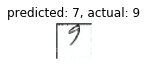

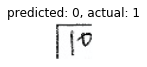

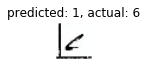

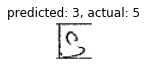

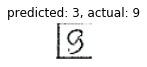

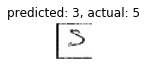

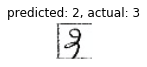

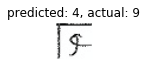

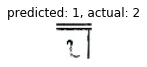

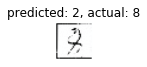

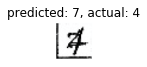

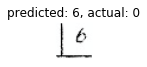

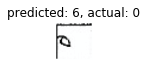

ValueError: num must be 1 <= num <= 25, not 26

<Figure size 432x288 with 0 Axes>

In [35]:
visualize_model(model_ft)

## Improved VGG model

In [8]:
from sklearn.model_selection import KFold

k_folds = 5

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=RANDOM_SEED)

In [9]:
data_path = '/home/mayankg/adv_cv/dataset_preprocessed'
input_size = 224

#Define Dataset from path
# transforms = transforms.Compose([
#         transforms.Resize(input_size),
#         #transforms.CenterCrop(input_size),
#         transforms.ToTensor()])
#         #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_dataset = CustomDataSet(data_path, transform=data_transforms['train'])
valid_dataset = CustomDataSet(data_path, transform=data_transforms['val'])

In [10]:
curr_fold = 0

train_id, test_id = None, None

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(train_dataset)):

    if fold != curr_fold:
        continue
    
    train_id = train_ids
    test_id = test_ids
    
    break
    
print(len(train_id), len(test_id))

59676 14919


In [11]:
# Sample elements randomly from a given list of ids, no replacement.
train_subsampler = torch.utils.data.SubsetRandomSampler(train_id)
test_subsampler = torch.utils.data.SubsetRandomSampler(test_id)

# Define data loaders for training and testing data in this fold
train_loader = torch.utils.data.DataLoader(
                  train_dataset, 
                  batch_size=batch_size, sampler=train_subsampler)
valid_loader = torch.utils.data.DataLoader(
                  valid_dataset,
                  batch_size=batch_size, sampler=test_subsampler)

In [12]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    
    model_ft = models.vgg16_bn(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    input_size = 224
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [13]:
# Create training and validation dataloaders
dataloaders_dict = {'train': train_loader, 'val': valid_loader}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.1.weight
	 features.1.bias
	 features.3.weight
	 features.3.bias
	 features.4.weight
	 features.4.bias
	 features.7.weight
	 features.7.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 features.11.weight
	 features.11.bias
	 features.14.weight
	 features.14.bias
	 features.15.weight
	 features.15.bias
	 features.17.weight
	 features.17.bias
	 features.18.weight
	 features.18.bias
	 features.20.weight
	 features.20.bias
	 features.21.weight
	 features.21.bias
	 features.24.weight
	 features.24.bias
	 features.25.weight
	 features.25.bias
	 features.27.weight
	 features.27.bias
	 features.28.weight
	 features.28.bias
	 features.30.weight
	 features.30.bias
	 features.31.weight
	 features.31.bias
	 features.34.weight
	 features.34.bias
	 features.35.weight
	 features.35.bias
	 features.37.weight
	 features.37.bias
	 features.38.weight
	 features.38.bias
	 features.40.weight
	 features.40.

In [15]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

In [17]:
save_path = "models_vgg/model_vgg16_best_"+ str(curr_fold) + ".pth"
torch.save(model_ft.state_dict(), save_path)

file = open("models_vgg/vgg16_best_res_"+str(curr_fold) + ".txt", "w")
file.write(str(hist) + "\n")

file.close()

In [19]:
for i in range(1, 5):
    
    curr_fold = i
    print("Starting Fold:", i)

    train_id, test_id = None, None

    # K-fold Cross Validation model evaluation
    for fold, (train_ids, test_ids) in enumerate(kfold.split(train_dataset)):

        if fold != curr_fold:
            continue

        train_id = train_ids
        test_id = test_ids

        break

    print(len(train_id), len(test_id))

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_id)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_id)

    # Define data loaders for training and testing data in this fold
    train_loader = torch.utils.data.DataLoader(
                      train_dataset, 
                      batch_size=batch_size, sampler=train_subsampler)
    valid_loader = torch.utils.data.DataLoader(
                      valid_dataset,
                      batch_size=batch_size, sampler=test_subsampler)
    
    # Initialize the model for this run
    model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)

    # Print the model we just instantiated
    #print(model_ft)

    # Create training and validation dataloaders
    dataloaders_dict = {'train': train_loader, 'val': valid_loader}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Send the model to GPU
    model_ft = model_ft.to(device)

    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.
    params_to_update = model_ft.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate
    model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

    save_path = "models_vgg/model_vgg16_best_"+ str(curr_fold) + ".pth"
    torch.save(model_ft.state_dict(), save_path)

    file = open("models_vgg/vgg16_best_res_"+str(curr_fold) + ".txt", "w")
    file.write(str(hist) + "\n")

    file.close()

Starting Fold: 1
59676 14919
Params to learn:
	 features.0.weight
	 features.0.bias
	 features.1.weight
	 features.1.bias
	 features.3.weight
	 features.3.bias
	 features.4.weight
	 features.4.bias
	 features.7.weight
	 features.7.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 features.11.weight
	 features.11.bias
	 features.14.weight
	 features.14.bias
	 features.15.weight
	 features.15.bias
	 features.17.weight
	 features.17.bias
	 features.18.weight
	 features.18.bias
	 features.20.weight
	 features.20.bias
	 features.21.weight
	 features.21.bias
	 features.24.weight
	 features.24.bias
	 features.25.weight
	 features.25.bias
	 features.27.weight
	 features.27.bias
	 features.28.weight
	 features.28.bias
	 features.30.weight
	 features.30.bias
	 features.31.weight
	 features.31.bias
	 features.34.weight
	 features.34.bias
	 features.35.weight
	 features.35.bias
	 features.37.weight
	 features.37.bias
	 features.38.weight
	 features.38.bias
	 feat

KeyboardInterrupt: 